In [1]:
### IMPORTS ###
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
from scipy import stats
from scipy.signal import savgol_filter
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from collections import defaultdict
import glob
import sys
import pdb
from dataset_characterization import dataset_characterization
import matplotlib.gridspec as gridspec
import config


outputdir = "C:\\Files\\UM\\ND\\SFN"
preprocessingdir = os.path.join("C:\\Files\\UM\\ND\\SFN","preprocessing_092024_no7822nofalcon")
characterizationdir = outputdir
perf_dir = 'C:\\Files\\UM\\ND\\big_nhp_dataset_code\\sfn_stuff' #dir to sfn_stuff
# This script is used to calculate the stability of the model performance over multiple days over multiple channels
# and store them in pandas dataframes for later use.

### FUNCTION TO COMPUTE CHANNEL TUNING ###

def compute_channel_tuning(data):
    # Check if data is a tuple and extract the dictionary if necessary
    if isinstance(data, tuple):
        if data[0] is None and isinstance(data[1], dict):
            data = data[1]
        elif isinstance(data[0], dict):
            data = data[0]
        else:
            print(f"Unexpected data structure: {type(data)}")
            return None

    # Extract relevant data
    finger_kinematics = data['finger_kinematics']
    sbp = data['sbp']
    
    channel_tuning = {}
    
    for i in range(sbp.shape[1]):  # Iterate over channels
        channel_data = sbp[:, i]
        
        # Check if channel_data or finger_kinematics are constant
        if np.all(channel_data == channel_data[0]) or np.all(finger_kinematics[:, 0] == finger_kinematics[0, 0]) or np.all(finger_kinematics[:, 1] == finger_kinematics[0, 1]):
            # If any are constant, set correlation to 0
            channel_tuning[f'sbp_channel_{i}'] = {
                'magnitude': 0,
                'angle': 0,
                'corr_index': 0,
                'corr_mrp': 0
            }
        else:
            # Compute correlation with index and mrp positions
            corr_index = stats.pearsonr(channel_data, finger_kinematics[:, 0])[0]
            corr_mrp = stats.pearsonr(channel_data, finger_kinematics[:, 1])[0]
            
            # Treat correlations as vector components
            magnitude = np.sqrt(corr_index**2 + corr_mrp**2)
            angle = np.degrees(np.arctan2(corr_mrp, corr_index))
            
            channel_tuning[f'sbp_channel_{i}'] = {
                'magnitude': magnitude,
                'angle': angle,
                'corr_index': corr_index,
                'corr_mrp': corr_mrp
            }
    
    return channel_tuning


In [2]:

### LOAD AND PREPROCESS DATA ###
# Approximate total number of datasets
total_datasets = 405

# Create a progress bar
#pbar = tqdm(total=total_datasets, desc="Processing datasets")

# Path to the folder containing pkl files (FIND THIS IN HISHAMS STUDENT FOLDER -> BIG DATASET -> AUTOTRIMMING AND PREPROCESSING)
data_folder = preprocessingdir

# Get list of pkl files
pkl_files = sorted(glob.glob(os.path.join(data_folder, '*.pkl')))

# Dictionary to store results
results = {}

# Process each pkl file
counter = 405
for file in pkl_files:
    sys.stdout.write(f"\r Date Processing: {file}")
    sys.stdout.flush()
    # Extract date from filename (assuming format like 'YYYY-MM-DD_data.pkl')
    date = pd.to_datetime(os.path.basename(file).split('_')[0])

    # Load data
    with open(file, 'rb') as f:
        data = pickle.load(f)
        
    # Compute channel tuning
    try:
        channel_tuning = compute_channel_tuning(data)
        if channel_tuning is not None:
            results[date] = channel_tuning
    except Exception as e:
        print(f"Error processing file {file}: {str(e)}")
        continue

    results[date] = channel_tuning

    counter += 1
    if counter == 405:
        break


 Date Processing: C:\Files\UM\ND\SFN\preprocessing_092024_no7822nofalcon\2024-02-05_preprocess.pkl

In [3]:
first_key = next(iter(results.keys()))
print(results[first_key]['sbp_channel_0'])
#result in magnitude, angle, corr_index, corr_mrp


{'magnitude': np.float64(0.14394727125448592), 'angle': np.float64(57.80558772331801), 'corr_index': np.float64(0.07669420634611936), 'corr_mrp': np.float64(0.12181467733631861)}


In [4]:
data_rows = []

# Iterate through the results dictionary
for date, channels in results.items():
    for channel, metrics in channels.items():
        magnitude = metrics['magnitude']
        angle = metrics['angle']
        channel_value = int(channel.split('_')[-1])
        data_rows.append({'date': date, 'channel': channel_value, 'magnitude': magnitude, 'angle': angle})

df = pd.DataFrame(data_rows)

print(df)

            date  channel  magnitude       angle
0     2020-01-27        0   0.143947   57.805588
1     2020-01-27        1   0.058501   56.621729
2     2020-01-27        2   0.151813   46.046582
3     2020-01-27        3   0.071023   92.921169
4     2020-01-27        4   0.043333  -78.980063
...          ...      ...        ...         ...
36955 2024-02-05       91   0.001958   43.645215
36956 2024-02-05       92   0.003359   14.123641
36957 2024-02-05       93   0.003158  -83.542574
36958 2024-02-05       94   0.000821 -101.286072
36959 2024-02-05       95   0.000836   40.480941

[36960 rows x 4 columns]


In [5]:
import plotters.stability_tuning as stability_tuning

stability_tuning.create_channelwise_tuning_dataframe(preprocessingdir,outputdir)

 Date Processing: C:\Files\UM\ND\SFN\preprocessing_092024_no7822nofalcon\2021-06-09_preprocess.pkl

KeyboardInterrupt: 

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# get number of dates from results
numdates = len(list(results.keys()))
print(numdates)

385


In [ ]:
print("yes" if 385 * 96 == 36960 else "no")

yes


In [ ]:
df = pd.read_csv(os.path.join(outputdir, 'channelwise_stability_tuning.csv'))
print(df)

             date  channel  magnitude       angle
0      2020-01-27        0   0.143947   57.805588
1      2020-01-27        1   0.058501   56.621729
2      2020-01-27        2   0.151813   46.046582
3      2020-01-27        3   0.071023   92.921169
4      2020-01-27        4   0.043333  -78.980063
...           ...      ...        ...         ...
36955  2024-02-05       91   0.001958   43.645215
36956  2024-02-05       92   0.003359   14.123641
36957  2024-02-05       93   0.003158  -83.542574
36958  2024-02-05       94   0.000821 -101.286072
36959  2024-02-05       95   0.000836   40.480941

[36960 rows x 4 columns]


In [ ]:
stability_tuning.create_channelwise_tuning_plot(outputdir)

KeyError: "None of ['date'] are in the columns"

In [ ]:
channel_number = 42
channel_data = df[df['channel'] == channel_number]

print(channel_data)

             date  channel  magnitude       angle
42     2020-01-27       42   0.120841 -121.071624
138    2020-01-30       42   0.119105 -127.364525
234    2020-02-04       42   0.061926 -121.746635
330    2020-02-05       42   0.053838  -80.056156
426    2020-02-06       42   0.050152 -106.020955
...           ...      ...        ...         ...
36522  2023-11-02       42   0.037470 -135.634152
36618  2023-12-11       42   0.057798  -76.662284
36714  2023-12-13       42   0.008136  -61.826771
36810  2024-01-16       42   0.050411 -104.418793
36906  2024-02-05       42   0.001782  -75.600533

[385 rows x 4 columns]


C:\Users\chang\AppData\Local\Temp\ipykernel_16876\507473199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_data['date'] = pd.to_datetime(channel_data['date'])


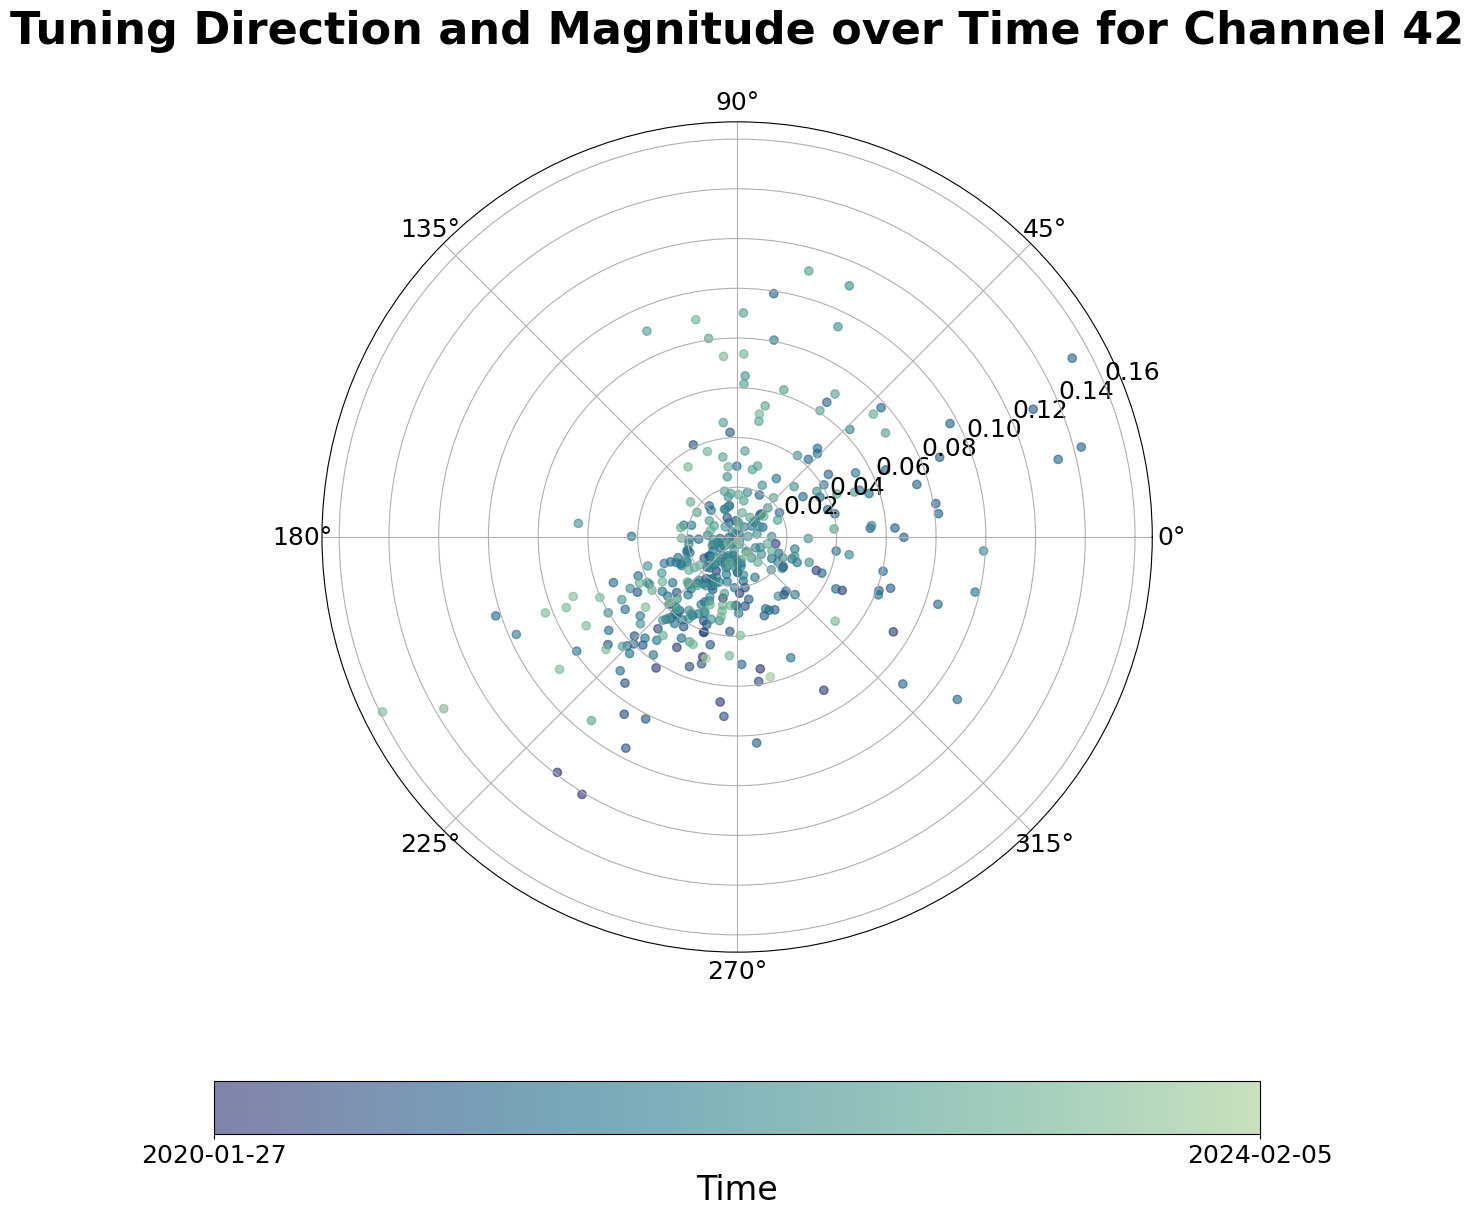

In [ ]:
channel_data['date'] = pd.to_datetime(channel_data['date'])
time_normalized = (channel_data['date'] - channel_data['date'].min()) / (channel_data['date'].max() - channel_data['date'].min())

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(12, 12))

# the good looking colour map
cmap = sns.color_palette('crest', as_cmap=True).reversed()

# the current colour map i used to see it clearer
#cmap = sns.color_palette('coolwarm', as_cmap=True)

scatter = ax.scatter(
    np.radians(channel_data['angle']),
    channel_data['magnitude'],
    c=time_normalized,
    cmap=cmap,
    alpha=0.6
)
cbar = fig.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('Time')
cbar.set_ticks([0, 1])
cbar.set_ticklabels([channel_data['date'].min().strftime('%Y-%m-%d'), channel_data['date'].max().strftime('%Y-%m-%d')])
ax.set_title(f'Tuning Direction and Magnitude over Time for Channel {channel_number}', va='bottom', pad=50)
plt.show()


          date  magnitude      angle
0   2020-01-27   0.049930 -57.849409
1   2020-01-30   0.043248 -38.961057
2   2020-02-04   0.042603 -50.812156
3   2020-02-05   0.040057 -42.234434
4   2020-02-06   0.039496 -32.648200
..         ...        ...        ...
380 2023-11-02   0.037056 -80.292654
381 2023-12-11   0.042842 -54.848525
382 2023-12-13   0.018174 -53.667432
383 2024-01-16   0.045279 -69.836936
384 2024-02-05   0.005525  -3.166510

[385 rows x 3 columns]


C:\Users\chang\AppData\Local\Temp\ipykernel_19800\2578298741.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


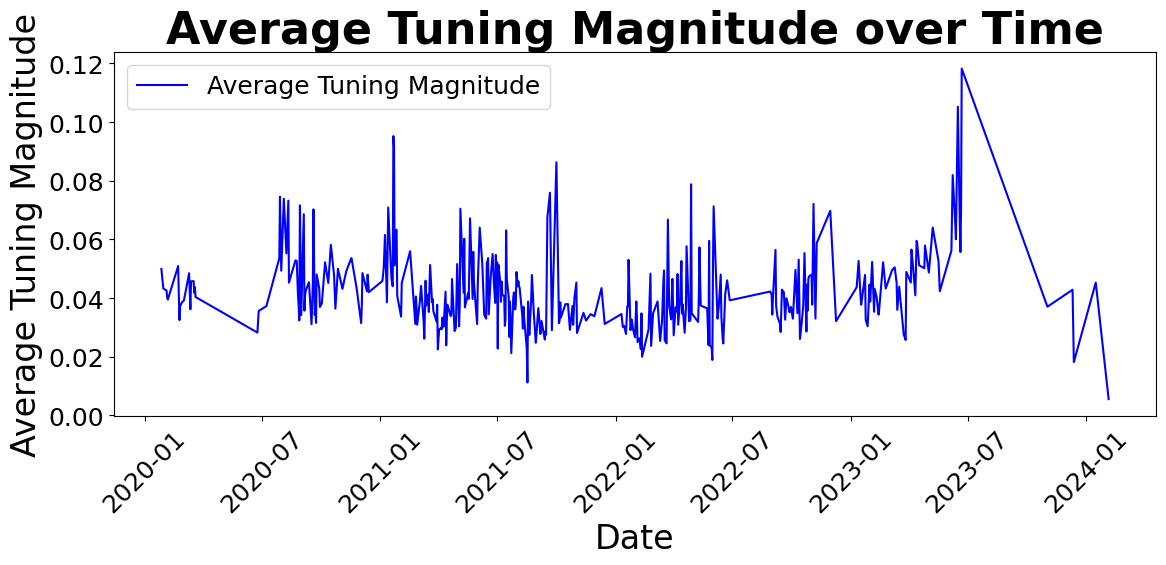

In [ ]:
# calculate the average tuning magnitude and angle for each day over all channels
df_avg = df.groupby('date').agg({'magnitude': 'mean', 'angle': 'mean'}).reset_index()
print(df_avg)

#plot the average tuning magnitude and angle for each day over all channels
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_avg['date'], df_avg['magnitude'], label='Average Tuning Magnitude', color='blue')
ax.set_xlabel('Date')

ax.set_ylabel('Average Tuning Magnitude')
ax.set_title('Average Tuning Magnitude over Time')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\chang\AppData\Local\Temp\ipykernel_19800\779307873.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


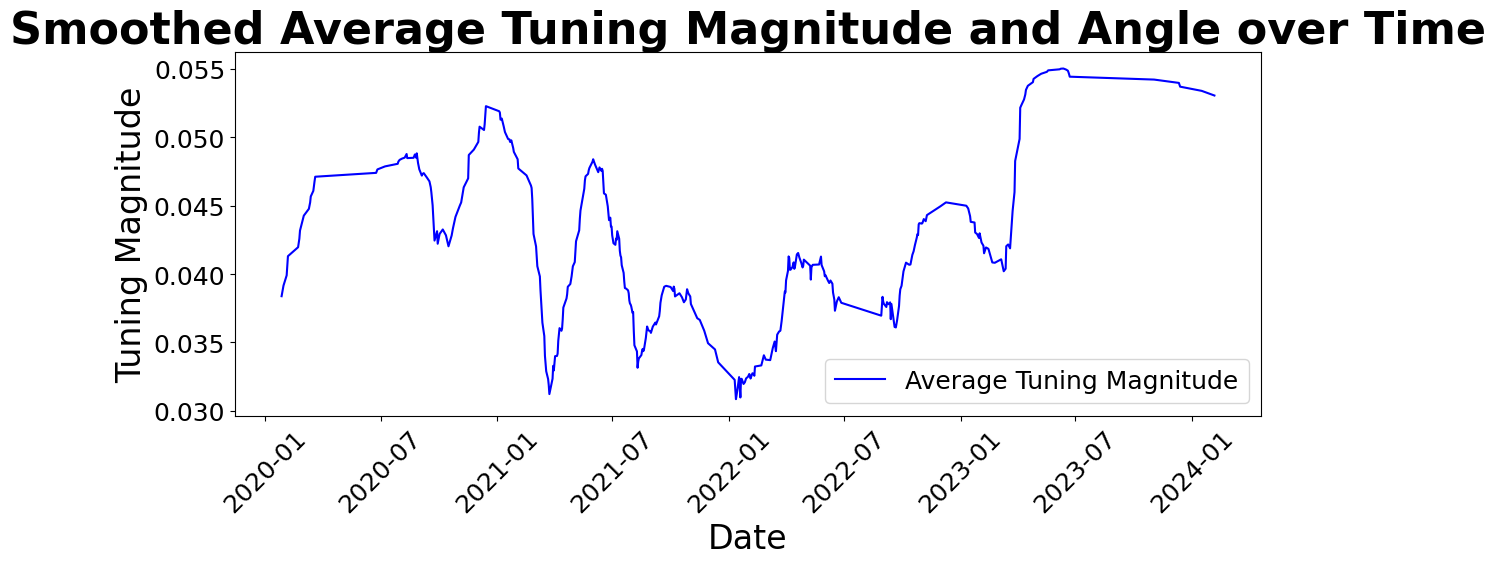

In [ ]:
#smooth the data using savgol filter
df_avg['magnitude_smooth'] = savgol_filter(df_avg['magnitude'], window_length=50, polyorder=2)

#plot the average tuning magnitude and angle for each day over all channels
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_avg['date'], df_avg['magnitude_smooth'], label='Average Tuning Magnitude', color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Tuning Magnitude')
ax.set_title('Smoothed Average Tuning Magnitude and Angle over Time')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()


C:\Users\chang\AppData\Local\Temp\ipykernel_19800\2432524263.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


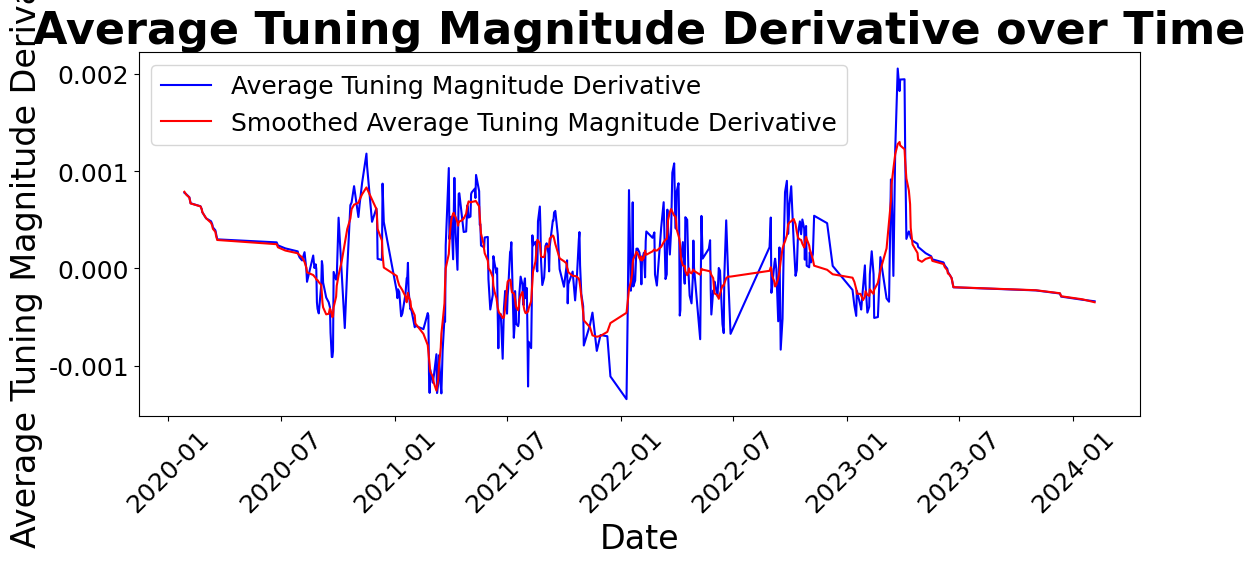

In [ ]:
# get derivative of the smoothed data
df_avg['magnitude_derivative'] = np.gradient(df_avg['magnitude_smooth'])
df_avg['magnitude_derivative_smoothed'] = savgol_filter(df_avg['magnitude_derivative'], window_length=20, polyorder=2)

#plot the derivative of the average tuning magnitude and angle for each day over all channels
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_avg['date'], df_avg['magnitude_derivative'], label='Average Tuning Magnitude Derivative', color='blue')
ax.plot(df_avg['date'], df_avg['magnitude_derivative_smoothed'], label='Smoothed Average Tuning Magnitude Derivative', color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Average Tuning Magnitude Derivative')
ax.set_title('Average Tuning Magnitude Derivative over Time')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\chang\AppData\Local\Temp\ipykernel_19800\1069614067.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


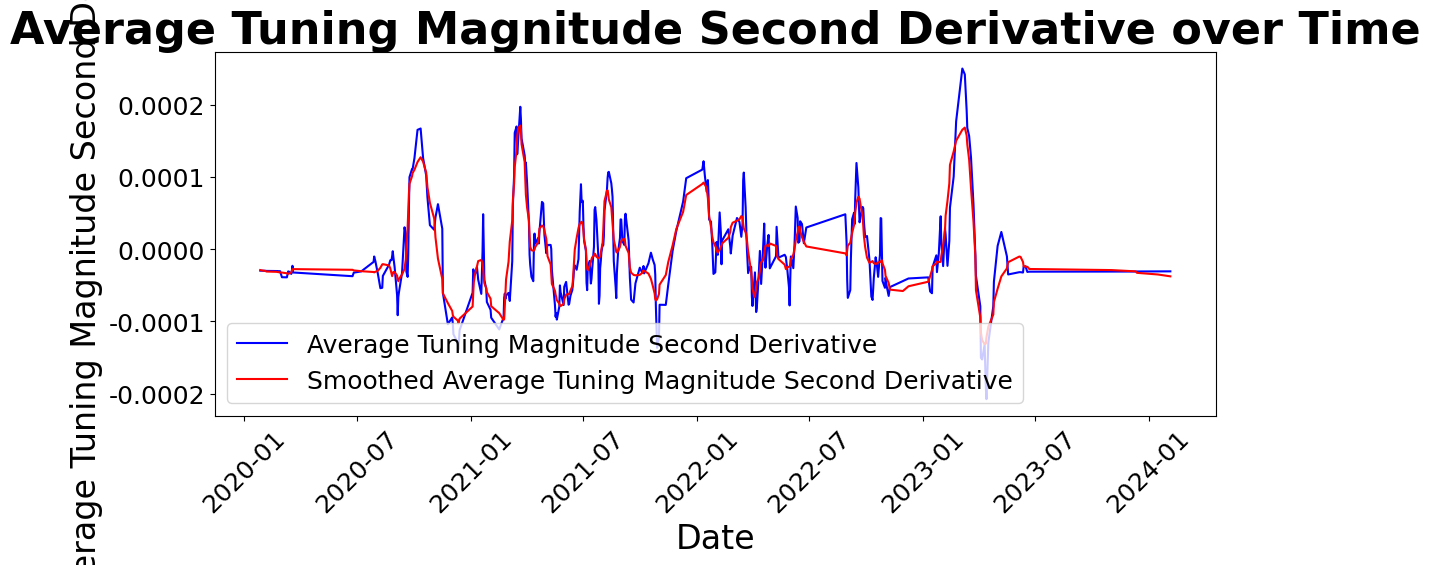

In [ ]:
# get second derivative of the smoothed data
df_avg['magnitude_second_derivative'] = np.gradient(df_avg['magnitude_derivative_smoothed'])
df_avg['magnitude_second_derivative_smoothed'] = savgol_filter(df_avg['magnitude_second_derivative'], window_length=20, polyorder=2)

#plot the second derivative of the average tuning magnitude and angle for each day over all channels
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_avg['date'], df_avg['magnitude_second_derivative'], label='Average Tuning Magnitude Second Derivative', color='blue')
ax.plot(df_avg['date'], df_avg['magnitude_second_derivative_smoothed'], label='Smoothed Average Tuning Magnitude Second Derivative', color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Average Tuning Magnitude Second Derivative')
ax.set_title('Average Tuning Magnitude Second Derivative over Time')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\chang\AppData\Local\Temp\ipykernel_19800\1044055323.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


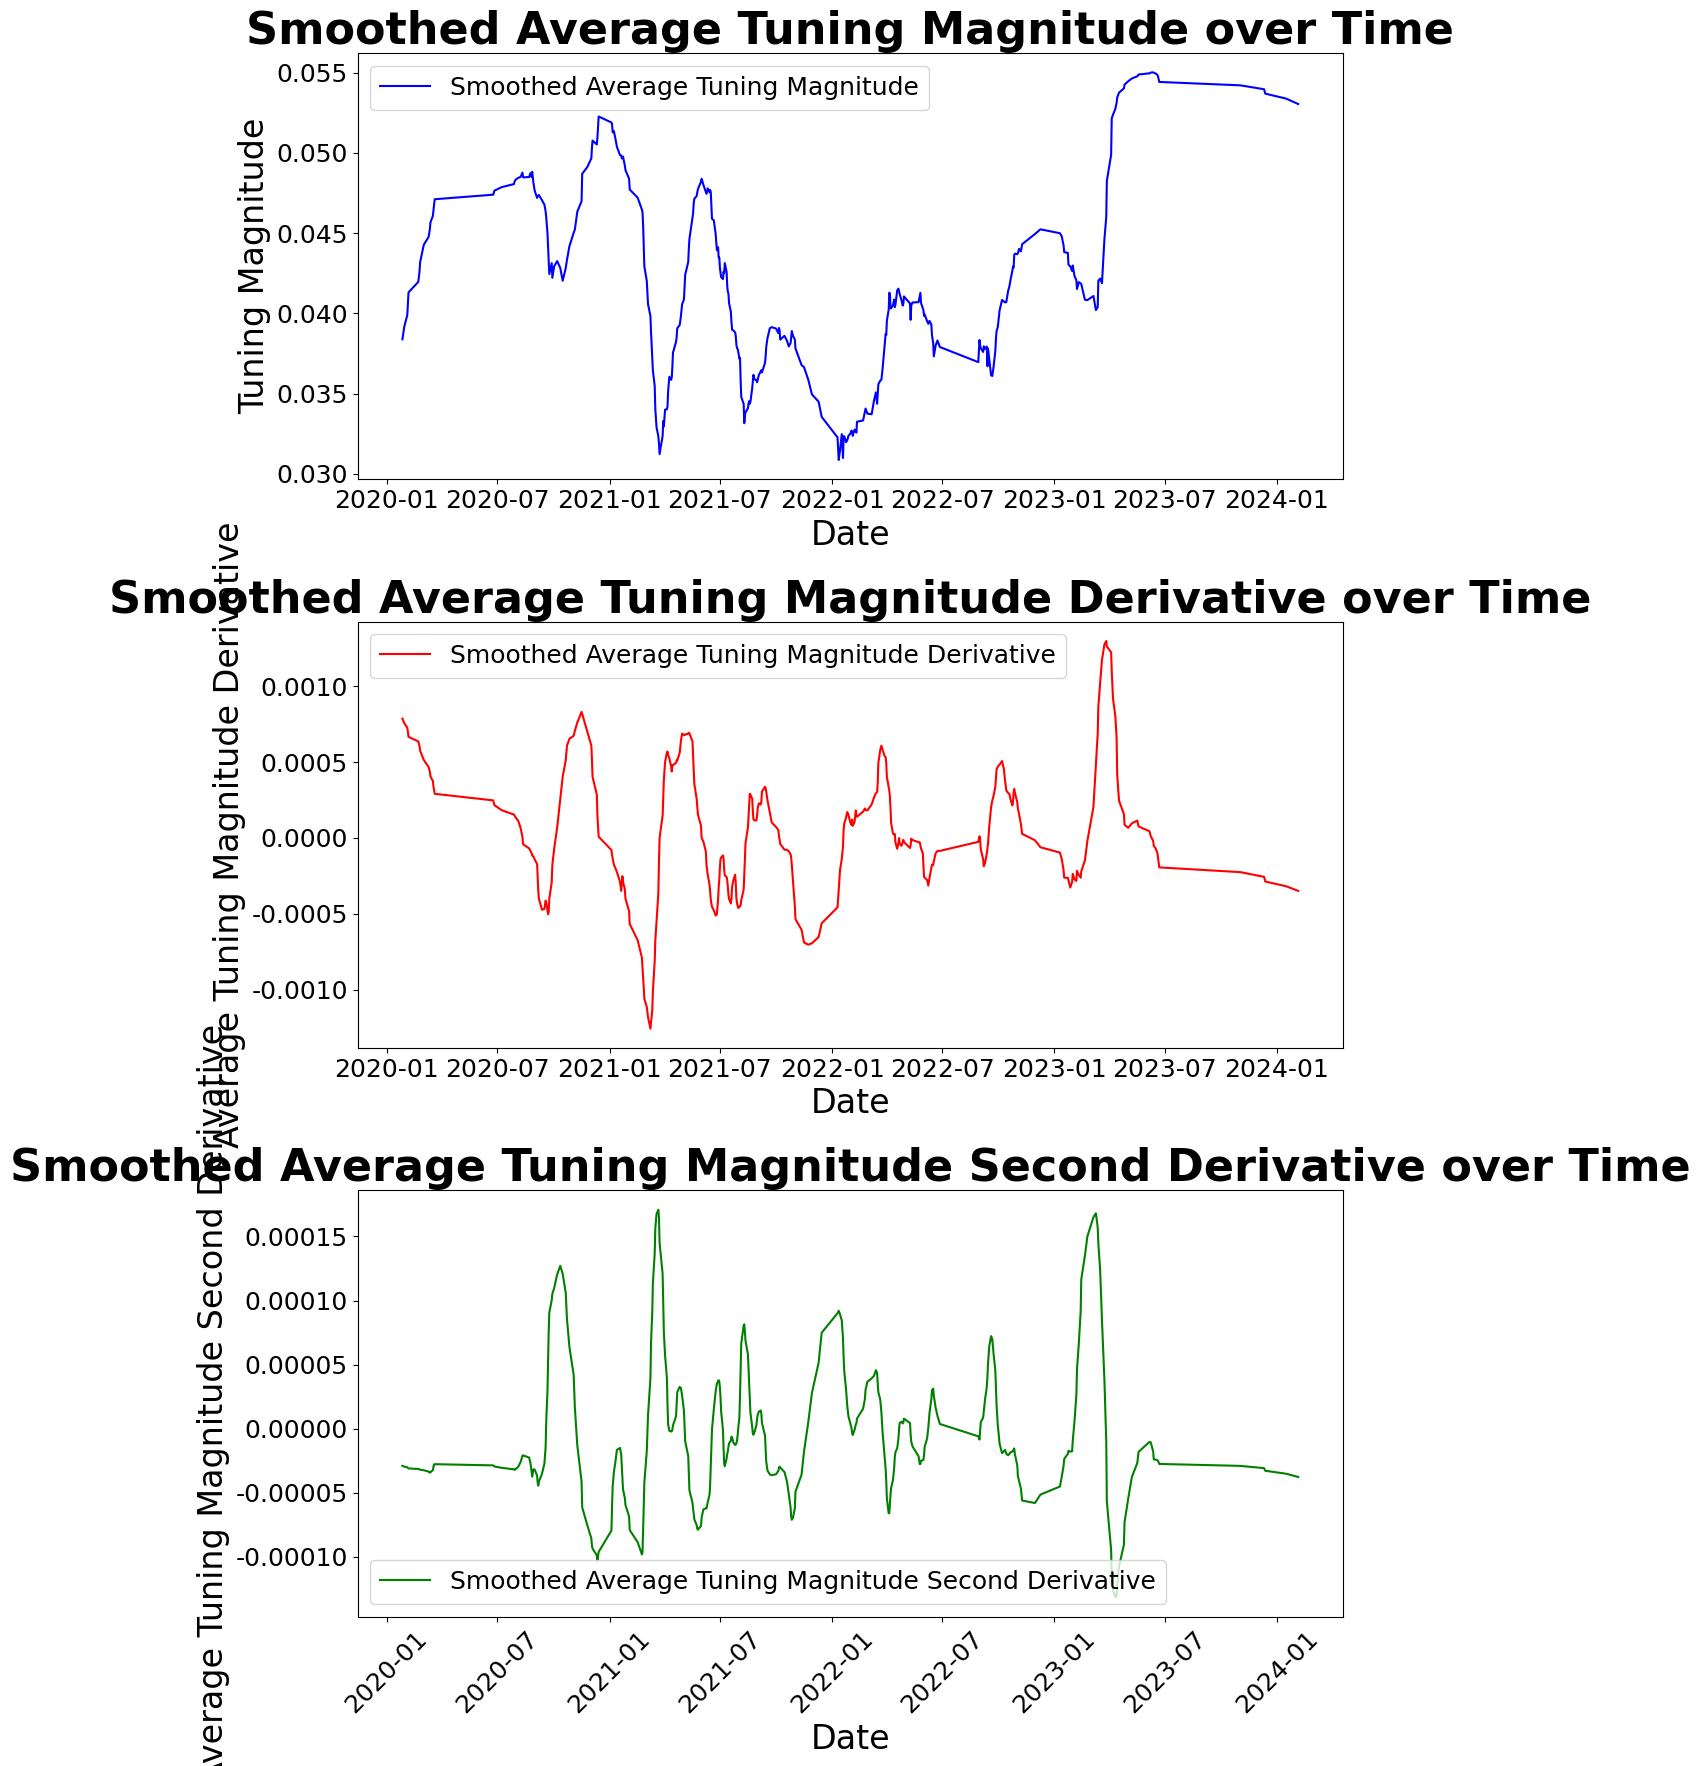

In [ ]:
# plot smoothed derivative, smoothed original data, and second derivative together on three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

# First subplot: Smoothed Average Tuning Magnitude
ax1.plot(df_avg['date'], df_avg['magnitude_smooth'], label='Smoothed Average Tuning Magnitude', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Tuning Magnitude')
ax1.set_title('Smoothed Average Tuning Magnitude over Time')
ax1.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Second subplot: Smoothed Average Tuning Magnitude Derivative
ax2.plot(df_avg['date'], df_avg['magnitude_derivative_smoothed'], label='Smoothed Average Tuning Magnitude Derivative', color='red')
ax2.set_xlabel('Date')
ax2.set_ylabel('Average Tuning Magnitude Derivative')
ax2.set_title('Smoothed Average Tuning Magnitude Derivative over Time')
ax2.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Third subplot: Smoothed Average Tuning Magnitude Second Derivative
ax3.plot(df_avg['date'], df_avg['magnitude_second_derivative_smoothed'], label='Smoothed Average Tuning Magnitude Second Derivative', color='green')
ax3.set_xlabel('Date')
ax3.set_ylabel('Average Tuning Magnitude Second Derivative')
ax3.set_title('Smoothed Average Tuning Magnitude Second Derivative over Time')
ax3.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
